# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [2]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

# 1. Exploring the data

In this section, I try to understand what is the training data that I have, and how suitable it is for fine-tuning a NLLB model.

In [3]:
import pandas as pd

In [4]:
# Define column names for the datasets
column_names_gos = ["id", "language", "gos"]
column_names_nld = ["id", "language", "nld"]

# Load the Dutch and Gronings sentences
gos_sentences = pd.read_csv("/tatoeba/gos_sentences.tsv.bz2", sep="\t", header=None, names=column_names_gos)
nld_sentences = pd.read_csv("/tatoeba/nld_sentences.tsv.bz2", sep="\t", header=None, names=column_names_nld)

# Extract the links.csv from links.tar.bz2
link_sentences = pd.read_csv("/tatoeba/links.tar.bz2", sep="\t", header=None, names=["origin", "translation"])

In [6]:
import re

zinnen = gos_sentences['gos']
woorden = [re.sub(r'[^\w\s]', '', zin).lower().split() for zin in zinnen]
alle_woorden = [woord for sublist in woorden for woord in sublist]
unieke_woorden = set(alle_woorden)
aantal_unieke_woorden = len(unieke_woorden)
print("Aantal unieke woorden:", aantal_unieke_woorden)
print(list(unieke_woorden)[:10])

Aantal unieke woorden: 4569
['dou', 'menaaiern', 'onder', 'besefde', 'mandels', 'woare', 'schrieft', 'navajo', 'volkse', 'bezoen']


In [7]:
# Merge the datasets to find translation pairs
tatoeba_raw = link_sentences.merge(nld_sentences, left_on="origin", right_on="id").merge(gos_sentences, left_on="translation", right_on="id")

# Select relevant columns
tatoeba_pairs = tatoeba_raw[["origin", "translation", "nld", "gos"]]

# Display the resulting DataFrame
print(len(tatoeba_pairs))
display(tatoeba_pairs.head())

# Optionally, save to a CSV file
tatoeba_pairs.to_csv("/tatoeba/tatoeba_pairs.csv", index=False)

8266


,origin,translation,nld,gos
0,5946,8106956,Wilt u een kopje koffie?,Willen joe n taske kovvie?
1,5949,12519478,We houden niet van regen.,Wie holden nait van regen.
2,5969,9051001,Vandaag is het 18 juni en het is de verjaardag...,Vandoag is t 18 juni en t is verjoardag van Mu...
3,5970,12504167,Wat is dat?,Wat is dat?
4,5971,8004896,Wat doe je?,Wat dust doe?


In [5]:
pd.options.display.max_colwidth = 80

In [6]:
trans_df = tatoeba_pairs
trans_df.sample(10)

,origin,translation,nld,gos
2903,6029929,8719940,Wat doe je op zo'n koude plek?,Wat dust op zo'n kolle stee.
1941,3493557,8116257,Zij stierf in zijn armen.,Zai sturf ien zien aarms.
6039,8671924,8741871,Probeer deze eens.,Perbaaier dizze ais.
6820,9483895,12494059,Dit werkt meestal.,Dit waarkt mainsttieds.
4475,7764432,12497824,Verdraaid!,Verdold!
5708,8384688,8072992,Spreek je Schots-Gaelisch?,Spreekst Skots-Goals?
682,719228,12499110,Ik ben thuis.,Ik bin thoes.
5399,8007961,8008443,Zijn vader stierf.,Zien pa sturf.
1897,3349937,8114880,Welk boek is dit?,Welk bouk is dit?
5186,7981004,8141871,Ik brei.,k Braai.


In [7]:
trans_df.isnull().sum()

origin         0
translation    0
nld            0
gos            0
dtype: int64

In [8]:
from sklearn.model_selection import train_test_split

# First split into train (98%) and temp (2%)
df_train, df_temp = train_test_split(tatoeba_pairs, test_size=0.02, random_state=9358)
# Then split the temp (2%) into validation (1%) and test (1%)
df_validate, df_test = train_test_split(df_temp, test_size=0.5, random_state=9358)

display(df_test)

,origin,translation,nld,gos
721,737685,8792026,Bijna iedereen was uitgenodigd.,Sikkom elkenain was nuigd.
2025,3560409,9179919,Wat kunt u aanbevelen?,Wat kinnen joe rekomdaaiern?
4748,7855747,7855746,Tom zei dat hij zou wachten.,Tom zee dat hai zol wachten.
1112,1056991,8837554,Waar staan de letters WHO voor?,Woar stoan ledders WHO veur?
2769,5362277,8715553,Er zit een scheur in.,Der zit n knitter ien.
...,...,...,...,...
5546,8216500,9073992,Er waren maar zes mensen op het feest.,Der waren mor zes lu op t feest.
1592,2332493,8107976,Ik zal het proberen.,k Zel t perbaaiern
4842,7899033,8141377,Hij had het druk.,Hai haar t drok.
2358,4401695,9324425,VN staat voor Verenigde Naties.,VN stoat veur Verainde Noatsies.


In [ ]:
# I did it differently above
# df_train = trans_df[trans_df.split=='train'].copy() # 49000 items
# df_dev = trans_df[trans_df.split=='dev'].copy()     # 500 items
# df_test = trans_df[trans_df.split=='test'].copy()   # 500 items

# 2. How well does the data fit into a NLLB tokenizer?

In [9]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

c:\Users\tbran\.conda\envs\NLLB\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

the `lang_code_to_id` attribute is deprecated. The logic is natively handled in the `tokenizer.adder_tokens_decoder` this attribute will be removed in `transformers` v4.38
the `fairseq_tokens_to_ids` attribute is deprecated. The logic is natively handled in the `tokenizer.adder_tokens_decoder` this attribute will be removed in `transformers` v4.38
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [30]:
smpl = df_train.sample(2000, random_state=1)

smpl['nld_toks'] = smpl.nld.apply(tokenizer.tokenize)
smpl['gos_toks'] = smpl.gos.apply(tokenizer.tokenize)

smpl['nld_words'] = smpl.nld.apply(word_tokenize)
smpl['gos_words'] = smpl.gos.apply(word_tokenize)

In [31]:
smpl.sample(15)[['gos', 'gos_words', 'gos_toks', 'nld', 'nld_words', 'nld_toks']]

,gos,gos_words,gos_toks,nld,nld_words,nld_toks
2643,Wie hebben n webstee.,"[Wie, hebben, n, webstee, .]","[▁Wie, ▁hebben, ▁n, ▁web, ste, e, .]",We hebben een website.,"[We, hebben, een, website, .]","[▁We, ▁hebben, ▁een, ▁website, .]"
6471,Joe eten joen soep.,"[Joe, eten, joen, soep, .]","[▁Joe, ▁eten, ▁jo, en, ▁so, ep, .]",U eet uw soep.,"[U, eet, uw, soep, .]","[▁U, ▁eet, ▁uw, ▁so, ep, .]"
7036,Hai gaait vot.,"[Hai, gaait, vot, .]","[▁Hai, ▁gaa, it, ▁vot, .]",Hij gaat weg.,"[Hij, gaat, weg, .]","[▁Hij, ▁gaat, ▁weg, .]"
5829,Mìnsen binnen daaier.,"[Mìnsen, binnen, daaier, .]","[▁M, ìn, sen, ▁binnen, ▁da, ai, er, .]",Mensen zijn dieren.,"[Mensen, zijn, dieren, .]","[▁Mens, en, ▁zijn, ▁dieren, .]"
2505,Mien bruier wuir kok.,"[Mien, bruier, wuir, kok, .]","[▁Mi, en, ▁bru, ier, ▁wu, ir, ▁kok, .]",Mijn broer werd kok.,"[Mijn, broer, werd, kok, .]","[▁Mijn, ▁broer, ▁werd, ▁kok, .]"
1638,Let kovver doar!,"[Let, kovver, doar, !]","[▁Let, ▁kov, ver, ▁doar, !]",Laat de koffer daar!,"[Laat, de, koffer, daar, !]","[▁Laat, ▁de, ▁ko, ffer, ▁daar, !]"
6374,Dit pampier is wit.,"[Dit, pampier, is, wit, .]","[▁Dit, ▁pam, pier, ▁is, ▁wit, .]",Dit papier is wit.,"[Dit, papier, is, wit, .]","[▁Dit, ▁papier, ▁is, ▁wit, .]"
3524,Dizze bloume is geel.,"[Dizze, bloume, is, geel, .]","[▁Diz, ze, ▁blo, ume, ▁is, ▁ge, el, .]",Deze bloem is geel.,"[Deze, bloem, is, geel, .]","[▁Deze, ▁blo, em, ▁is, ▁ge, el, .]"
4794,k Zel sukkeloa eten.,"[k, Zel, sukkeloa, eten, .]","[▁k, ▁Zel, ▁suk, k, eloa, ▁eten, .]",Ik zal chocolade eten.,"[Ik, zal, chocolade, eten, .]","[▁Ik, ▁zal, ▁cho, co, lade, ▁eten, .]"
203,Vandoag is n naasjonoale feestdag.,"[Vandoag, is, n, naasjonoale, feestdag, .]","[▁V, ando, ag, ▁is, ▁n, ▁naas, j, ono, ale, ▁feest, dag, .]",Vandaag is een nationale feestdag.,"[Vandaag, is, een, nationale, feestdag, .]","[▁Vanda, ag, ▁is, ▁een, ▁nationale, ▁feest, dag, .]"


In [32]:
stats = smpl[['nld_toks', 'gos_toks', 'nld_words', 'gos_words']].map(len).describe()
stats

,nld_toks,gos_toks,nld_words,gos_words
count,2000.000000,2000.000000,2000.000000,2000.00000
mean,6.818500,7.944000,5.608000,5.43000
std,3.211186,3.886183,2.539992,2.46153
min,2.000000,2.000000,2.000000,2.00000
25%,5.000000,6.000000,4.000000,4.00000
50%,6.000000,7.000000,5.000000,5.00000
75%,8.000000,9.000000,6.000000,6.00000
max,36.000000,44.000000,31.000000,30.00000


In [34]:
print(stats.nld_toks['mean'] / stats.nld_words['mean'])
print(stats.gos_toks['mean'] / stats.gos_words['mean'])

1.2158523537803139
1.4629834254143648


In [35]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


Good news: both for Russian and Tyvan, the NLLB tokenizer seems to produce around 2 tokens per word (more precisely, 2.3 and 1.8), which means that the translation quality of fine-tuned NLLB may be decent even without vocabulary extension.

One more check: how often does the <unk> token happen in the tokenizer output for Tyvan? If this is too often, we need to fix it somehow

In [36]:
texts_with_unk = [text for text in tqdm(trans_df.gos) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

100%|██████████| 7304/7304 [00:00<00:00, 15656.81it/s]

3


In [37]:
# just 3 unknowns so lets print them:
display(texts_with_unk)

# import random
# s = random.sample(texts_with_unk, 5)
# s

['„Wat dustoe mit dij mizze?” „Dij is veur op eerbaaien.” „Arregat! Wie doun der room op!”',
 'k Wil geern da’s dat besefst.',
 'k Docht da’s noar boeten stoardest.']

Apparently, most of the texts with 3634 unknown tokens just have some punctuation unfamiliar to the NLLB tokenizer.

This is because the NLLB model was pretrained on normalized texts. If we reproduce the normalization, most of the problems would be fixed.

In [38]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [39]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

100%|██████████| 3/3 [00:00<?, ?it/s]

0


Indeed, after normalizing texts, none of them contain unknown tokens. We will use this as one more piece of evidence that we don't have to update the tokenizer vocabulary to use it with Tyvan.

# 3 (optional). Expanding the vocabulary

# 4. Adding a new language tag to the tokenizer and model

In [40]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [41]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
# print(len(tokenizer))
# print(tokenizer.convert_ids_to_tokens([256202, 256203]))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [33]:
# we probably need transformers<=4.33 for this to work.

# def fix_tokenizer(tokenizer, new_lang='gos_Latn'):
#     """
#     Add a new language token to the tokenizer vocabulary
#     (this should be done each time after its initialization)
#     """
#     old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
#     tokenizer.lang_code_to_id[new_lang] = old_len-1
#     tokenizer.id_to_lang_code[old_len-1] = new_lang
#     # always move "mask" to the last position
#     tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

#     tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
#     tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
#     if new_lang not in tokenizer._additional_special_tokens:
#         tokenizer._additional_special_tokens.append(new_lang)
#     # clear the added token encoder; otherwise a new token may end up there by mistake
#     tokenizer.added_tokens_encoder = {}
#     tokenizer.added_tokens_decoder = {}

# fix_tokenizer(tokenizer)
# print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
# print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'tyv_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# # this is consistent now, wow!
# added_token_id = tokenizer.convert_tokens_to_ids('gos_Cyrl')
# similar_lang_id = tokenizer.convert_tokens_to_ids('nld_Cyrl')
# print(added_token_id, similar_lang_id)

In [42]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
# model.resize_token_embeddings(len(tokenizer))

In [36]:
# # moving the embedding for "mask" to its new position
# model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# # initializing new language token with a token of a similar language
# model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

# 5. Preparing the training loop

In [43]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [44]:
model.cuda();

In [45]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [46]:
batch_size = 8  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 90 #no idea if it should be shorter
warmup_steps = 100
training_steps = 1000

In [47]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [51]:
LANGS = [('nld', 'nld_Latn'), ('gos', 'gos_Latn')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))
# (['Wie binnen Tom zien dochters.'], ['Wij zijn Toms dochters.'], 'gos_Latn', 'nld_Latn')

(['Noa n gobbe roekt t graas zo lekker.'], ['Na een stevige regenbui geurt het gras zo heerlijk.'], 'gos_Latn', 'nld_Latn')


In [52]:
MODEL_SAVE_PATH = '/NLLB-GOS/models/nllb-nld-gos-v1'

# 6. The training loop

In [53]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 100 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 100 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 1/1000 [00:01<32:13,  1.94s/it]

0 7.174554347991943


 10%|█         | 100/1000 [02:07<19:14,  1.28s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


100 3.343932531847812


 20%|██        | 200/1000 [04:19<19:45,  1.48s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


200 2.489005459481804


 30%|███       | 300/1000 [06:30<14:50,  1.27s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


300 2.0886508382337037


 40%|████      | 400/1000 [08:44<12:29,  1.25s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


400 1.8449242165186757


 50%|█████     | 500/1000 [10:56<10:47,  1.29s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


500 1.6752270817786397


 60%|██████    | 600/1000 [13:03<08:59,  1.35s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


600 1.5527677685890142


 70%|███████   | 700/1000 [15:18<06:27,  1.29s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


700 1.4478190343683524


 80%|████████  | 800/1000 [17:37<04:45,  1.43s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


800 1.3597165219736902


 90%|█████████ | 900/1000 [19:50<01:57,  1.18s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


900 1.2923969420274672


100%|██████████| 1000/1000 [22:01<00:00,  1.32s/it]


In [54]:
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 200}


('/NLLB-GOS/models/nllb-nld-gos-v1\\tokenizer_config.json',
 '/NLLB-GOS/models/nllb-nld-gos-v1\\special_tokens_map.json',
 '/NLLB-GOS/models/nllb-nld-gos-v1\\sentencepiece.bpe.model',
 '/NLLB-GOS/models/nllb-nld-gos-v1\\added_tokens.json')

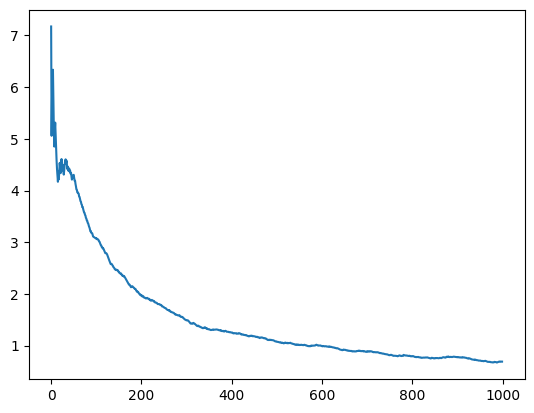

In [55]:
pd.Series(losses).ewm(100).mean().plot();

In [56]:
def translate(text, src_lang='nld_Latn', tgt_lang='gos_Latn', a=16, b=1.5, max_input_length=700, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [68]:
while True:
    tekst = input()
    transl = translate(tekst)
    print('nld->gos')
    print(transl)
    print('gos->nld')
    print(translate(transl, src_lang='gos_Latn', tgt_lang='nld_Latn'))
    print('---')

In [65]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_train)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['Hij is naar Tokyo verhuisd.']
['Hai is noar Tokio vervoard.']
['Hai is noar Tokio verhoesd.']


In [66]:
!ls -alsh $MODEL_SAVE_PATH

'ls' is not recognized as an internal or external command,
operable program or batch file.


# 6. Using the model

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

c:\Users\tbran\.conda\envs\NLLB\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
trans_df = pd.read_csv('/gd/MyDrive/datasets/nlp/tyvan/for_translator.csv')
trans_df.dropna(subset=['ru', 'tyv'], inplace=True)
df_train, df_devtest = train_test_split(trans_df, test_size=1000, random_state=1)
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=1)

In [2]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [3]:
# def fix_tokenizer(tokenizer, new_lang='gos_Latn'):
#     """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
#     old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
#     tokenizer.lang_code_to_id[new_lang] = old_len-1
#     tokenizer.id_to_lang_code[old_len-1] = new_lang
#     # always move "mask" to the last position
#     tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

#     tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
#     tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
#     if new_lang not in tokenizer._additional_special_tokens:
#         tokenizer._additional_special_tokens.append(new_lang)
#     # clear the added token encoder; otherwise a new token may end up there by mistake
#     tokenizer.added_tokens_encoder = {}
#     tokenizer.added_tokens_decoder = {}

In [6]:
model_load_name = '/NLLB-GOS/models/nllb-nld-gos-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
# fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
def translate(text, src_lang='nld_Latn', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [195]:
t = 'Daar, kijk maar even goed, het kan best zijn dat het nog familie van je is.' #"мөңгүн үр чыткаш карарар"
print(translate(t, 'nld_Latn', 'gos_Latn'))
#t_translated translate(t, 'nld_Latn', 'gos_Latn')
# ['серебро от времени чернеет']

['Daar, kiek mor even goud, t kin best wèd dat t nog femilie van die is.']


In [196]:
translate(t, 'nld_Latn', 'gos_Latn', do_sample=True, num_beams=2, temperature=1.5)

["doar, kiek mor even goud, t kin best wezen da't nog famlie van die is."]

In [ ]:
def batched_translate(texts, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [ ]:
rus_translated = batched_translate(df_dev.tyv, src_lang='tyv_Cyrl', tgt_lang='rus_Cyrl')

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
df_dev['rus_translated'] = [translate(t, 'tyv_Cyrl', 'rus_Cyrl')[0] for t in tqdm(df_dev.tyv)]
df_dev['tyv_translated'] = [translate(t, 'rus_Cyrl', 'tyv_Cyrl')[0] for t in tqdm(df_dev.ru)]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [ ]:
xx, yy = ['течёт холод'], ['несёт холодом']
print(bleu_calc.corpus_score(xx, [yy]))
print(chrf_calc.corpus_score(xx, [yy]))
print(chrf_calc.corpus_score(yy, [xx]))

BLEU = 0.00 0.0/0.0/0.0/0.0 (BP = 1.000 ratio = 1.000 hyp_len = 2 ref_len = 2)
chrF2++ = 36.75
chrF2++ = 42.30


In [ ]:
print(bleu_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(chrf_calc.corpus_score(df_dev['rus_translated'].tolist(), [df_dev['ru'].tolist()]))
print(bleu_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))
print(chrf_calc.corpus_score(df_dev['tyv_translated'].tolist(), [df_dev['tyv'].tolist()]))

BLEU = 24.14 52.5/30.4/18.9/12.1 (BP = 0.981 ratio = 0.981 hyp_len = 2281 ref_len = 2324)
chrF2++ = 49.49
BLEU = 23.41 52.1/31.0/18.9/11.3 (BP = 0.966 ratio = 0.967 hyp_len = 2292 ref_len = 2371)
chrF2++ = 50.89


In [ ]:
pd.options.display.max_colwidth = 100

In [ ]:
df_dev.sample(10, random_state=5)[['tyv', 'ru', 'tyv_translated', 'rus_translated']]

,tyv,ru,tyv_translated,rus_translated
row_id,,,,
37635,ыяк сактып алыр,намотать на ус,аксынга өттүрер,твёрдо запомнить
42465,чиик үлетпүр,лёгкая промышленность,чиик үлетпүр,лёгкая промышленность
27916,аяк бусту берген,чашка разбилась,аяк бусту берген,чашка лопнула
78401,оларны маш-салатче салыр,выложить их на маш-салат,оларны маш-салатче салыр,выложить их в маш-салат
74168,соус хоюг кылдыр хайынмаан шаанда,пока соус не заварится густо,соус хоюг хайынмаан шаанда,пока соус не сварится густо
61972,шиви,ель,шиви,еловая кобыла
8377,соондан арай боорда шимчээр,тащиться вслед,соондан чүткүүр,еле двинуться вслед
109242,АКШ,США,АКШ,США
38832,бир-ле черден соок үрүп тур,откуда-то несёт холодом,бир-ле черден соок аппар чыдыр,откуда-то течёт холод


In [ ]:
print((df_dev.ru == df_dev.rus_translated).mean())
print((df_dev.tyv == df_dev.tyv_translated).mean())

0.26
0.25


In [ ]:
!pip install editdistance

In [ ]:
import editdistance

def ed_similarity(text1, text2):
    return max(0, 1 - editdistance.eval(text1, text2) / min(len(text1), len(text2)))

print(ed_similarity('кот', 'собака'))
print(ed_similarity('кот', 'кит'))

0
0.6666666666666667


In [ ]:
pd.Series([ed_similarity(row.ru, row.rus_translated) for row in df_dev.itertuples()]).describe()

count    500.000000
mean       0.516367
std        0.392761
min        0.000000
25%        0.116013
50%        0.507009
75%        1.000000
max        1.000000
dtype: float64

In [ ]:
pd.Series([ed_similarity(row.tyv, row.tyv_translated) for row in df_dev.itertuples()]).describe()

count    500.000000
mean       0.506007
std        0.382357
min        0.000000
25%        0.111111
50%        0.504902
75%        0.979730
max        1.000000
dtype: float64

In [ ]:
df_dev.index.name = "row_id"

In [ ]:
df_dev.to_csv(model_load_name + "/dev_set_translated.tsv", sep="\t")

Evaluating another model (with extended vocabulary)

In [ ]:
model_load_name = '/gd/MyDrive/models/nllb-rus-tyv-v2-extvoc'

In [ ]:
cfg = AutoConfig.from_pretrained(model_load_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name + "/pytorch_model_60k.bin", config=cfg).cuda()

In [ ]:
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
df_dev['rus_translated2'] = [translate(t, 'tyv_Cyrl', 'rus_Cyrl')[0] for t in tqdm(df_dev.tyv)]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
df_dev['tyv_translated2'] = [translate(t, 'rus_Cyrl', 'tyv_Cyrl')[0] for t in tqdm(df_dev.ru)]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print(bleu_calc.corpus_score(df_dev['rus_translated2'].tolist(), [df_dev['ru'].tolist()]))
print(chrf_calc.corpus_score(df_dev['rus_translated2'].tolist(), [df_dev['ru'].tolist()]))
print(bleu_calc.corpus_score(df_dev['tyv_translated2'].tolist(), [df_dev['tyv'].tolist()]))
print(chrf_calc.corpus_score(df_dev['tyv_translated2'].tolist(), [df_dev['tyv'].tolist()]))

BLEU = 25.18 52.4/31.3/20.4/13.3 (BP = 0.976 ratio = 0.976 hyp_len = 2269 ref_len = 2324)
chrF2++ = 49.85
BLEU = 23.22 51.6/29.4/18.3/11.6 (BP = 0.975 ratio = 0.975 hyp_len = 2312 ref_len = 2371)
chrF2++ = 49.87


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()

In [ ]:
df_dev['rus_translated3'] = [translate(t, 'tyv_Cyrl', 'rus_Cyrl')[0] for t in tqdm(df_dev.tyv)]
df_dev['tyv_translated3'] = [translate(t, 'rus_Cyrl', 'tyv_Cyrl')[0] for t in tqdm(df_dev.ru)]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print(bleu_calc.corpus_score(df_dev['rus_translated3'].tolist(), [df_dev['ru'].tolist()]))
print(chrf_calc.corpus_score(df_dev['rus_translated3'].tolist(), [df_dev['ru'].tolist()]))
print(bleu_calc.corpus_score(df_dev['tyv_translated3'].tolist(), [df_dev['tyv'].tolist()]))
print(chrf_calc.corpus_score(df_dev['tyv_translated3'].tolist(), [df_dev['tyv'].tolist()]))

BLEU = 23.06 51.1/29.1/18.1/11.5 (BP = 0.978 ratio = 0.978 hyp_len = 2273 ref_len = 2324)
chrF2++ = 48.56
BLEU = 26.12 53.4/32.5/21.0/13.6 (BP = 0.985 ratio = 0.985 hyp_len = 2336 ref_len = 2371)
chrF2++ = 52.60


In [ ]:
df_dev['rus2eng'] = [translate(t, 'tyv_Cyrl', 'eng_Latn')[0] for t in tqdm(df_dev.tyv)]
df_dev['tyv2eng'] = [translate(t, 'rus_Cyrl', 'eng_Latn')[0] for t in tqdm(df_dev.ru)]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Results with num_beams=1:
```
V1
BLEU = 23.21 51.2/29.1/18.0/11.8 (BP = 0.978 ratio = 0.978 hyp_len = 2273 ref_len = 2324)
chrF2++ = 47.88
BLEU = 22.03 51.5/29.7/17.9/10.4 (BP = 0.952 ratio = 0.953 hyp_len = 2260 ref_len = 2371)
chrF2++ = 49.37
V2
BLEU = 24.08 50.9/29.5/19.1/12.3 (BP = 0.988 ratio = 0.988 hyp_len = 2297 ref_len = 2324)
chrF2++ = 48.96
BLEU = 22.50 50.5/28.5/17.7/11.1 (BP = 0.974 ratio = 0.974 hyp_len = 2310 ref_len = 2371)
chrF2++ = 48.85
V3
BLEU = 22.25 49.8/27.8/17.2/11.0 (BP = 0.983 ratio = 0.983 hyp_len = 2284 ref_len = 2324)
chrF2++ = 47.89
BLEU = 25.28 52.2/31.2/20.0/13.1 (BP = 0.989 ratio = 0.989 hyp_len = 2346 ref_len = 2371)
chrF2++ = 51.87
````

Results with 4 beams:
```
V1
BLEU = 24.14 52.5/30.4/18.9/12.1 (BP = 0.981 ratio = 0.981 hyp_len = 2281 ref_len = 2324)
chrF2++ = 49.49
BLEU = 23.41 52.1/31.0/18.9/11.3 (BP = 0.966 ratio = 0.967 hyp_len = 2292 ref_len = 2371)
chrF2++ = 50.89
V2
BLEU = 25.18 52.4/31.3/20.4/13.3 (BP = 0.976 ratio = 0.976 hyp_len = 2269 ref_len = 2324)
chrF2++ = 49.85
BLEU = 23.22 51.6/29.4/18.3/11.6 (BP = 0.975 ratio = 0.975 hyp_len = 2312 ref_len = 2371)
chrF2++ = 49.87
V3
BLEU = 23.06 51.1/29.1/18.1/11.5 (BP = 0.978 ratio = 0.978 hyp_len = 2273 ref_len = 2324)
chrF2++ = 48.56
BLEU = 26.12 53.4/32.5/21.0/13.6 (BP = 0.985 ratio = 0.985 hyp_len = 2336 ref_len = 2371)
chrF2++ = 52.60
```

Which means:
* For all directions and models, beam search improves the results
* Longer training builds up quality for Tyvan, but decreases it for Russian.

```
                                  | tyv->rus | rus->tyv
Model v1 (no vocabulary update):  |
    no beam search                |   23.21  |  22.03
    num_beams = 4                 |   24.14  |  23.41
Model v2 (with vocabulary update):|
    no beam search                |   24.08  |  22.50
    num_beams = 4                 |   25.18  |  23.22
```

In [ ]:
df_dev.to_csv(model_load_name + "/dev_set_translated.tsv", sep="\t")

Here are some examples of how translation has changed:

In [ ]:
df_dev.sample(5, random_state=1)[['gos', 'nld', 'nld_translated']]

,tyv,ru,rus_translated
row_id,,,
5442,транспорт херекселдерин ажыглаарының база шимчээшкинниң айыыл чок чоруунуң дүрүмнери,правила безопасности движения и эксплуатации транспортных средств,правила безопасности движения и эксплуатации транспортных средств
57777,аъш-чем садыы,продовольственный магазин,продовольственный магазин
104130,"Бүгү чүве төнген, бойлаан.","Все было кончено, потеряно.","Все было кончено, самостоятельно."
49344,фокуска кирбес,не попасть в фокус,не попасть в фокус
28319,рекорд тургузар,установить рекорд,поставить рекорд


In [ ]:
df_dev.sample(20, random_state=1)[[
    'tyv', 'tyv_translated', 'tyv_translated2', 'tyv_translated3', 'tyv2eng',
    'ru', 'rus_translated', 'rus_translated2', 'rus_translated3', 'rus2eng',
]]

,tyv,tyv_translated,tyv_translated2,tyv_translated3,tyv2eng,ru,rus_translated,rus_translated2,rus_translated3,rus2eng
row_id,,,,,,,,,,
5442,транспорт херекселдерин ажыглаарының база шимчээшкинниң айыыл чок чоруунуң дүрүмнери,шимчээшкинниң болгаш транспорт аймаан ажыглаарының айыыл чок чоруунуң дүрүмнери,транспорт аймаан шимчээшкининиң болгаш ажыглаарының айыыл чок чоруунуң дүрүмнери,транспорт аймаан шимчээшкининиң болгаш транспорт аймаан ажыглаарының айыыл чок чоруунуң дүрүмнери,ң болгаш транспорт аймаан ажыглаарының айыыл чок чоруунуң дүрүмнери,правила безопасности движения и эксплуатации транспортных средств,правила безопасности движения и эксплуатации транспортных средств,правила эксплуатации транспортных средств и безопасности движения,правила безопасности эксплуатации транспортных средств и движения,дүрүмнер транспорт херекселдерин ажыглаарының болгаш шимчээшкинниң айыыл чок чоруунуң дугайында
57777,аъш-чем садыы,аъш-чем садыы,аъш-чем садыы,аъш-чем садыы,садыы,продовольственный магазин,продовольственный магазин,продовольственный магазин,продовольственный магазин,садыы
104130,"Бүгү чүве төнген, бойлаан.","Шупту чүве доозулган, читкен.","Шупту чүве төнген, читкен.","Бүгү чүве бойлаан, читкен.","-даа, читкен-даа.","Все было кончено, потеряно.","Все было кончено, самостоятельно.","Все кончилось, разошёлся.","Все кончено, кончено.","-ла, бүгү чүве кончилось."
49344,фокуска кирбес,илби-шидиге алзыр арга чок,илбиге алыспас,илби-шидиге туттурбас,гге күш четпес,не попасть в фокус,не попасть в фокус,не попасться в фокусы,не попасть на фокус,г
28319,рекорд тургузар,рекорд тургузар,рекорд тургузар,рекорд тургузар,г тургузар,установить рекорд,поставить рекорд,установить рекорд,установить рекорд,г тургузар
43534,чурукту делгээр,чурукту делгээр,чурук делгээр,чурукту делгээр,ң чурукту делгээр,выставлять картину,выставлять картину,развернуть картину,экспонировать картину,чурукту делгередип чуруур
37159,ылап хөделир,ылап хөделир,бүзүрелдиг хөделир,ылап хөделир,г хөделир,действовать наверняка,действовать аккуратно,действовать наверняка,действовать наверняка,г хөделир
36993,колдуктап алгаш чоруур,шыңганның адаанга көдүрүп алгаш чоруур,колдук адаанга аппаар,колдуктап алгаш чоруур,г шыгжаар,нести под мышкой,нести под мышками,носить под мышкой,нести под мышкой,алгаш чоруур
116009,Копривничко-Крижевачка,Копривничко-Крижевачка,Копривничко-Крижевачка,Копривничко-Крижевачка,чко-Крижевачка,Копривничко-Крижевачка,Копривничко-Крижевачка,Копривничко-Крижевачка,Копривничко-Крижевачка,вничко-Крижевачка


In [54]:
cols = ['ind', 'gos', 'nld']
splits = {'train': df_train[df_train.index<=49_454], 'test': df_test, 'dev': df_validate}
df_joint = []
for k, v in splits.items():
    v = v[cols].copy()
    v.index.name = "row_id"
    v['split'] = k
    df_joint.append(v)
df_joint = pd.concat(df_joint)
df_joint.shape

KeyError: "None of [Index(['ind', 'tyv', 'ru'], dtype='object')] are in the [columns]"

In [ ]:
df_joint.sample(5)

,ind,tyv,ru,split
row_id,,,,
314,328,Өг-бүле бүрүзү эвээш дээрге-ле 500-600 ивини азырап өстүрзүн.,Пусть на каждую семью было хотя бы по 500-600 оленей.,train
4376,4390,Өрээл аяннаны берген,Комната приняла хороший вид,train
13377,13392,кым-бир кижи-биле силер деп чугаалажыр,быть на вы с кем-либо,train
91144,97279,"Идээледир чемнениринде база эки чүү-даа чүве чок, ынчангаш арай эвээшти чиңер.","Ничего хорошего нет и в переедании, так что ешьте поменьше.",dev
307,321,"Оларның аразында 14 суурда 500 четпес, а 8 суурда 250 хире чурттакчы бар.","Среди них в 14 селах менее 500, в восьми - менее 250 человек.",train


In [ ]:
df_joint.to_csv("/gd/MyDrive/datasets/nlp/tyvan/rus_tyv_parallel_50k.tsv", sep="\t")

# Publishing the model to HF

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Your token has been saved in your

In [ ]:
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig

In [ ]:
def fix_tokenizer(tokenizer, new_lang='tyv_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [ ]:
model_load_name = '/gd/MyDrive/models/nllb-rus-tyv-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name)
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
upload_repo = "slone/nllb-rus-tyv-v1"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/slone/nllb-rus-tyv-v1/commit/e45e25aa62c8487aaa7050d804f9851ae01e353a', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='e45e25aa62c8487aaa7050d804f9851ae01e353a', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model_load_name = '/gd/MyDrive/models/nllb-rus-tyv-v2-extvoc'
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
cfg = AutoConfig.from_pretrained(model_load_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name + "/pytorch_model_60k.bin", config=cfg)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
upload_repo = "slone/nllb-rus-tyv-v2-extvoc"
tokenizer.push_to_hub(upload_repo)
model.push_to_hub(upload_repo)

sentencepiece.bpe.model:   0%|          | 0.00/5.14M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.51G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/slone/nllb-rus-tyv-v2-extvoc/commit/48e9b1269b037fe08280bfec990c189e5748bccd', commit_message='Upload M2M100ForConditionalGeneration', commit_description='', oid='48e9b1269b037fe08280bfec990c189e5748bccd', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'tyv_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'tyv_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', '<mask>', 'tyv_Cyrl']
[256202, 256204, 256203]


Testing that it works

In [ ]:
MODEL_URL = 'slone/nllb-rus-tyv-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_URL)
tokenizer = NllbTokenizer.from_pretrained(MODEL_URL, force_download=True)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
def translate(
    text,
    model,
    tokenizer,
    src_lang='rus_Cyrl',
    tgt_lang='tyv_Cyrl',
    max_length='auto',
    num_beams=4,
    no_repeat_ngram_size=4,
    n_out=None,
    **kwargs
):
    tokenizer.src_lang = src_lang
    encoded = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    if max_length == 'auto':
        max_length = int(32 + 2.0 * encoded.input_ids.shape[1])
    model.eval()
    generated_tokens = model.generate(
        **encoded.to(model.device),
        forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
        max_length=max_length,
        num_beams=num_beams,
        no_repeat_ngram_size=no_repeat_ngram_size,
        num_return_sequences=n_out or 1,
        **kwargs
    )
    out = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
    if isinstance(text, str) and n_out is None:
        return out[0]
    return out

In [ ]:
translate("красная птица", model=model, tokenizer=tokenizer)

'кызыл куш'

In [ ]:
translate("красная птица", model=model, tokenizer=tokenizer, tgt_lang='eng_Latn')

': кызыл куш'

In [ ]:
lang_to_code = {
    'Русский | Russian': 'rus_Cyrl',
    'Тувинский | Tyvan': 'tyv_Cyrl',
}

In [ ]:
def translate_wrapper(text, src, trg, correct=None):
    src_lang = lang_to_code.get(src)
    tgt_lang = lang_to_code.get(trg)
    if src == trg:
        return 'Please choose two different languages'
    print(text, src, trg)
    result = translate(
        text=text,
        model=model,
        tokenizer=tokenizer,
        src_lang=src_lang,
        tgt_lang=tgt_lang,
    )
    return result

In [ ]:
translate_wrapper("красная птица", 'Русский | Russian', 'Тувинский | Tyvan')

красная птица Русский | Russian Тувинский | Tyvan


'кызыл куш'